## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# imports
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# importing the data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-02-03 00:44:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2020-02-03 00:44:57 (129 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [0]:
# converting to a data frame
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

In [0]:
df = pd.read_csv('house-votes-84.data',
                 header=None,
                 names=column_headers, 
                 na_values='?')

In [0]:
# recoding the votes to be numeric
df = df.replace({'y':1, 'n':0})
df.head(10)

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
9,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [0]:
df.shape

(435, 17)

In [0]:
# dropping the NaN values for a clean df
df_clean = df.dropna(axis=0)

In [0]:
df_clean.shape

(232, 17)

In [0]:
# defining our confidence interval function
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return(mean, mean - interval, mean + interval)

In [0]:
# confidence intervals for a few topics

water_project = df_clean['water-project']
confidence_interval(water_project)

# the confidence interval tells us that the mean is 0.46, and we can be 95%
# confident that the population mean will lie within between 0.396 and 0.525 
# in the context of our data, the mean dictates that this topic leans republican

(0.46120689655172414, 0.3965846075395787, 0.5258291855638696)

In [0]:
budget = df_clean['budget']
confidence_interval(budget)

# the confidence interval tells us that the mean is 0.53, and we can be 95%
# confident that the population mean will lie within between 0.465 and 0.594
# in the context of our data, the mean dictates that this topic leans democrat

(0.5301724137931034, 0.46547286579616826, 0.5948719617900385)

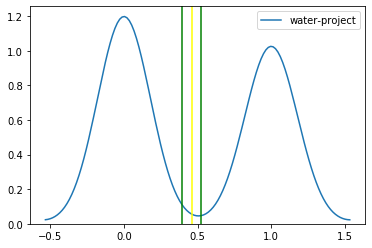

In [0]:
sns.kdeplot(water_project)
CI = confidence_interval(water_project)
plt.axvline(x=CI[1], color='green')
plt.axvline(x=CI[2], color='green')
plt.axvline(x=CI[0], color='yellow');

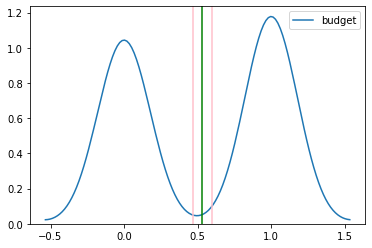

In [0]:
sns.kdeplot(budget)
CI = confidence_interval(budget)
plt.axvline(x=CI[1], color='pink')
plt.axvline(x=CI[2], color='pink')
plt.axvline(x=CI[0], color='green');

In [0]:
# reading in the dataframe for Titanic
url = 'https://raw.githubusercontent.com/austinlasseter/pandas_visualization/master/data/titanic.csv'

titanic = pd.read_csv(url)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,male,22.0,7.2500,Southampton
1,1,1,female,38.0,71.2833,Cherbourg
2,1,3,female,26.0,7.9250,Southampton
3,1,1,female,35.0,53.1000,Southampton
4,0,3,male,35.0,8.0500,Southampton


In [0]:
# mapping cabin class as a categorical variable
titanic['cabin_class'] = titanic['Pclass'].map({1:'first', 2:'second', 3:'third'})
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,cabin_class
0,0,3,male,22.0,7.2500,Southampton,third
1,1,1,female,38.0,71.2833,Cherbourg,first
2,1,3,female,26.0,7.9250,Southampton,third
3,1,1,female,35.0,53.1000,Southampton,first
4,0,3,male,35.0,8.0500,Southampton,third


In [0]:
# crosstab
x_titanic = pd.crosstab(titanic['Sex'], titanic['cabin_class'], margins=True)
x_titanic

cabin_class,first,second,third,All
Sex,,,,
female,83,74,102,259
male,101,99,253,453
All,184,173,355,712


In [0]:
# defining variables for the calculation of Chi Squared
row_sums = x_titanic.iloc[0:2, 3].values
col_sums = x_titanic.iloc[2, 0:3].values
print(row_sums)
print(col_sums)

[259 453]
[184 173 355]


In [0]:
total = x_titanic.loc['All', 'All']
total

712

In [0]:
# defining a function for expected value
expected = []
for i in range(len(row_sums)):
  expected_row=[]
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)

In [0]:
# checking out the expected values
print(expected[0])
print(expected[1])

[ 66.93258427  62.93117978 129.13623596]
[117.06741573 110.06882022 225.86376404]


In [0]:
observed = pd.crosstab(titanic['Sex'], titanic['cabin_class']).values
observed

array([[ 83,  74, 102],
       [101,  99, 253]])

In [0]:
# formula for Chi Squared Test
chi_squared_stat = ((observed - expected)**2 / (expected)).sum()
chi_squared_stat

18.08484036123574

In [0]:
# calculating the degrees of freedom
dof = (len(row_sums) - 1)*(len(col_sums) - 1)
dof

2

In [0]:
# Chi Squared using stats
stats.chi2_contingency(observed)

(18.08484036123574,
 0.00011828422058509222,
 2,
 array([[ 66.93258427,  62.93117978, 129.13623596],
        [117.06741573, 110.06882022, 225.86376404]]))

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)